In [3]:
# The first model gives the conductance model as we discussed
# The second model is an simplified one using constant g
# The third model is the simple GRU model, should be the strongest one

'Data Preprocessing'
import torch
import math
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# get index of currently selected device
print(torch.cuda.current_device()) # returns 0 in my case

# get number of GPUs available
print(torch.cuda.device_count()) # returns 1 in my case

# get the name of the device
print(torch.cuda.get_device_name(0)) # good old Tesla K80

def snake_scan(img):
    'Converts a 32x32 image to a 32x96 array with snake-like row ordering'
    if len(img.shape) != 3:
        raise ValueError('Input image must be a 3D array')
    
    channels, rows, cols = img.shape
    snake = np.zeros((rows, cols * channels), dtype=img.dtype)
    for r in range(rows):
        row_data = img[:, r, :].flatten()  # Flattening each row into a 1D array of 96 elements
        if r % 2 == 1:
            row_data = row_data[::-1]  # Reversing the order for alternate rows
        snake[r] = row_data
    return snake

def stride(input_data, stride):
    'turn [batch_size, sequence_length, input_size] into [batch_size, sequence_length*input_size/stride, input_size]'
    batch_size, sequence_length, input_size = input_data.shape
    # flatten the input data to put sequence and input size together
    input_data = input_data.reshape(batch_size, -1)
    # append zeros to make sure the last pixel can be fed as the first pixel of the next sequence
    n = input_size - (sequence_length*input_size)%stride

    input_data = input_data.cpu()
    input_data = input_data.numpy()
    input_data = np.append(input_data, np.zeros((batch_size, n)), axis=1)
    input_data = torch.tensor(input_data)
    #print(input_data.shape)
    output_data = torch.zeros(batch_size, sequence_length*input_size//stride, input_size)
    for i in range(sequence_length*input_size//stride):
        # if stride = input size, then the output data is the same as input data
        #print(i)

        output_data[:,i,:] = input_data[:,i*stride:i*stride+input_size]
        #print(output_data[batch,i,:])

    return output_data

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Lambda

transform = transforms.Compose([
    ToTensor(),
    Lambda(lambda x: torch.tensor(snake_scan(x.numpy())))
])

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    download = True,
    transform = transform     
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    download = True,
    transform = transform
)




'Hyperparameters'
from torch import nn
import torch.nn.functional as F

input_size = 8
sequence_length = 28*28//input_size
hidden_size = 24
num_layers = 1
num_classes = 10
batch_size = 40
num_epochs = 10
learning_rate = 0.01
stride_number = 4

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=0),
}
loaders
'''
for i, (images, labels) in enumerate(loaders['train']):
    images = images.reshape(-1, sequence_length, input_size).to(device)
    images = stride(images, stride_number).to(device)
    print(images.shape)
    print(labels.shape)
    print(len(loaders['train']))
    break
'''

'Model Definition'

class CB_RNNcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CB_RNNcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.W = torch.nn.Parameter(torch.empty(self.hidden_size, self.hidden_size))
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and P_z become tied          
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # initialise e as a random float between 0 and 1
        self.e = torch.nn.Parameter(torch.rand(1))
        self.e_p = torch.nn.Parameter(torch.rand(1))

        # Voltage rate
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # dt is a constant
        self.dt = nn.Parameter(torch.tensor(1.0), requires_grad = False)
        self.z_high = 0.2

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        for w in self.W, self.P:
            glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        self.v_t_history = []
        self.z_t_history = []
        

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        e = self.softplus(self.e)
        e_p = self.softplus(self.e_p)
        K = e * self.softplus(self.W)
        P_z = e_p * self.softplus(self.P)


        ### Update Equations ###
        input_mask = torch.ones_like(self.P)
        input_mask[self.hidden_size//2:,:] = 0
        P = self.P * input_mask

        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t =self.dt * self.z_high* self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(P_z, x) + self.b_z)
        self.v_t = (1 - self.z_t) * self.v_t + self.dt * (torch.matmul(self.W, self.r_t) + torch.matmul(P, x) + self.b_v)
        self.v_t = torch.transpose(self.v_t, 0, 1)    

        self.v_t_history.append(self.v_t.clone().detach())
        self.z_t_history.append(self.z_t.clone().detach())              

class CB_RNN_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(CB_RNN_batch, self).__init__()
        self.rnncell = CB_RNNcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.v_t             
            
class CB_RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CB_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = CB_RNN_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        # Reshaping the outputs such that it can be fit into the fully connected layer
        output_mask = torch.ones_like(out)
        output_mask[:,0:self.hidden_size//2] = 0
        out = out * output_mask
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = CB_RNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)


Using device: cuda
0
1
NVIDIA GeForce RTX 4070 Laptop GPU
CB_RNN(
  (lstm): CB_RNN_batch(
    (rnncell): CB_RNNcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=24, out_features=10, bias=True)
)
Epoch [1/10], Step [750/1500], Training Accuracy: 49.90
Epoch [1/10], Step [1500/1500], Training Accuracy: 44.30
Epoch [2/10], Step [750/1500], Training Accuracy: 60.00
Epoch [2/10], Step [1500/1500], Training Accuracy: 41.40
Epoch [3/10], Step [750/1500], Training Accuracy: 60.80
Epoch [3/10], Step [1500/1500], Training Accuracy: 41.60
Epoch [4/10], Step [750/1500], Training Accuracy: 63.20


KeyboardInterrupt: 

In [6]:
'Testing Accuracy'
# Test the model
model.eval()
v_t_history = []
z_t_history = []
labelslist = []

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.X_history = []
        model.lstm.rnncell.U_history = []
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        v_t_history.append(model.lstm.rnncell.v_t_history)
        z_t_history.append(model.lstm.rnncell.z_t_history)
        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))

# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()





#Accuracy of the model:65.16%

Accuracy of the model:59.69%


In [13]:
#open document
import pickle
# create a document

with open('03_history.pkl', 'wb') as f:
    pickle.dump(v_t_history, f)
    pickle.dump(z_t_history, f)
    pickle.dump(labelslist, f)
    pickle.dump(P, f)
    pickle.dump(W, f)
    pickle.dump(read_out, f)
    pickle.dump(test_acc, f)
    f.close()

In [16]:
def convert_history(history_list):
    concatenated_history = []
    for batch in history_list:
        # Convert each tensor in the batch to numpy and append to a new list
        batch_history = [tensor.cpu().numpy() for tensor in batch]
        # Stack along a new dimension to keep batch data separate
        concatenated_history.append(np.stack(batch_history))
    # Concatenate all the batch data along the first dimension
    return np.concatenate(concatenated_history, axis=0)


def average_image(X_history, labelslist):

    neuronimage = []
    labelslist_array = convert_history(labelslist)
    order= np.argsort(labelslist_array.flatten())
    labelslist_array = labelslist_array.flatten()[order]
    # find number of 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    _, counts = np.unique(labelslist_array, return_counts=True)
    X  = convert_history(X_history)
    X = X.reshape((250, 196, 24, 40))
    X = X.transpose(0, 3, 1, 2)
    X = X.reshape((10000, 196, 24))
    k=0
    for i in range(10):
        X_label = X[k:k+counts[i],:,:]
        X_label = X_label.mean(axis=0)
        neuronimage.append(X_label)
        k += counts[i]
    neuronimage = np.array(neuronimage)
    return neuronimage


In [4]:
%matplotlib ipympl

In [18]:
import matplotlib.pyplot as plt
# import colour
import matplotlib.colors as mcolors
import numpy as np

v_nit = average_image(v_t_history, labelslist)
z_nit = average_image(z_t_history, labelslist)

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
print(X_nit.shape)
print(U_nit.shape)
plt.figure()
for i in range(12):
    plt.scatter(X_nit[0, :, i], U_nit[0, :, i], c=np.arange(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('U')
plt.show()

for i in range(12):
    plt.scatter(X_nit[0, :, i+12], U_nit[0, :, i+12], c=np.arange(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
plt.scatter(v_nit[0, :, 0], z_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('v_t')
plt.ylabel('z_t')
plt.show()

plt.figure()
plt.scatter(v_nit[0, :, 0], U_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('v_t')
plt.ylabel('U')
plt.show()

plt.figure()
plt.scatter(X_nit[0, :, 0], z_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('z_t')
plt.show()



NameError: name 'X_nit' is not defined

In [20]:
# generate (24,10,4) histograms
# divide time into 4 parts, ta -- time averaged
def timeaverage(X_nit):
    X_nit= X_nit.transpose(2, 0, 1)
    X_ta = X_nit.reshape(24, 10, 4, 196//4).mean(axis=-1)
    X_ta_input = X_ta[:12, :, :]
    X_ta_output = X_ta[12:, :, :]
    return X_ta_input, X_ta_output

v_ta_input, v_ta_output = timeaverage(v_nit)
z_ta_input, z_ta_output = timeaverage(z_nit)



### Superposed Histogram

In [20]:
input_size = 8
sequence_length = 28*28//input_size
hidden_size = 24
num_layers = 1
num_classes = 10
batch_size = 40
num_epochs = 5
learning_rate = 0.01
stride_number = 4

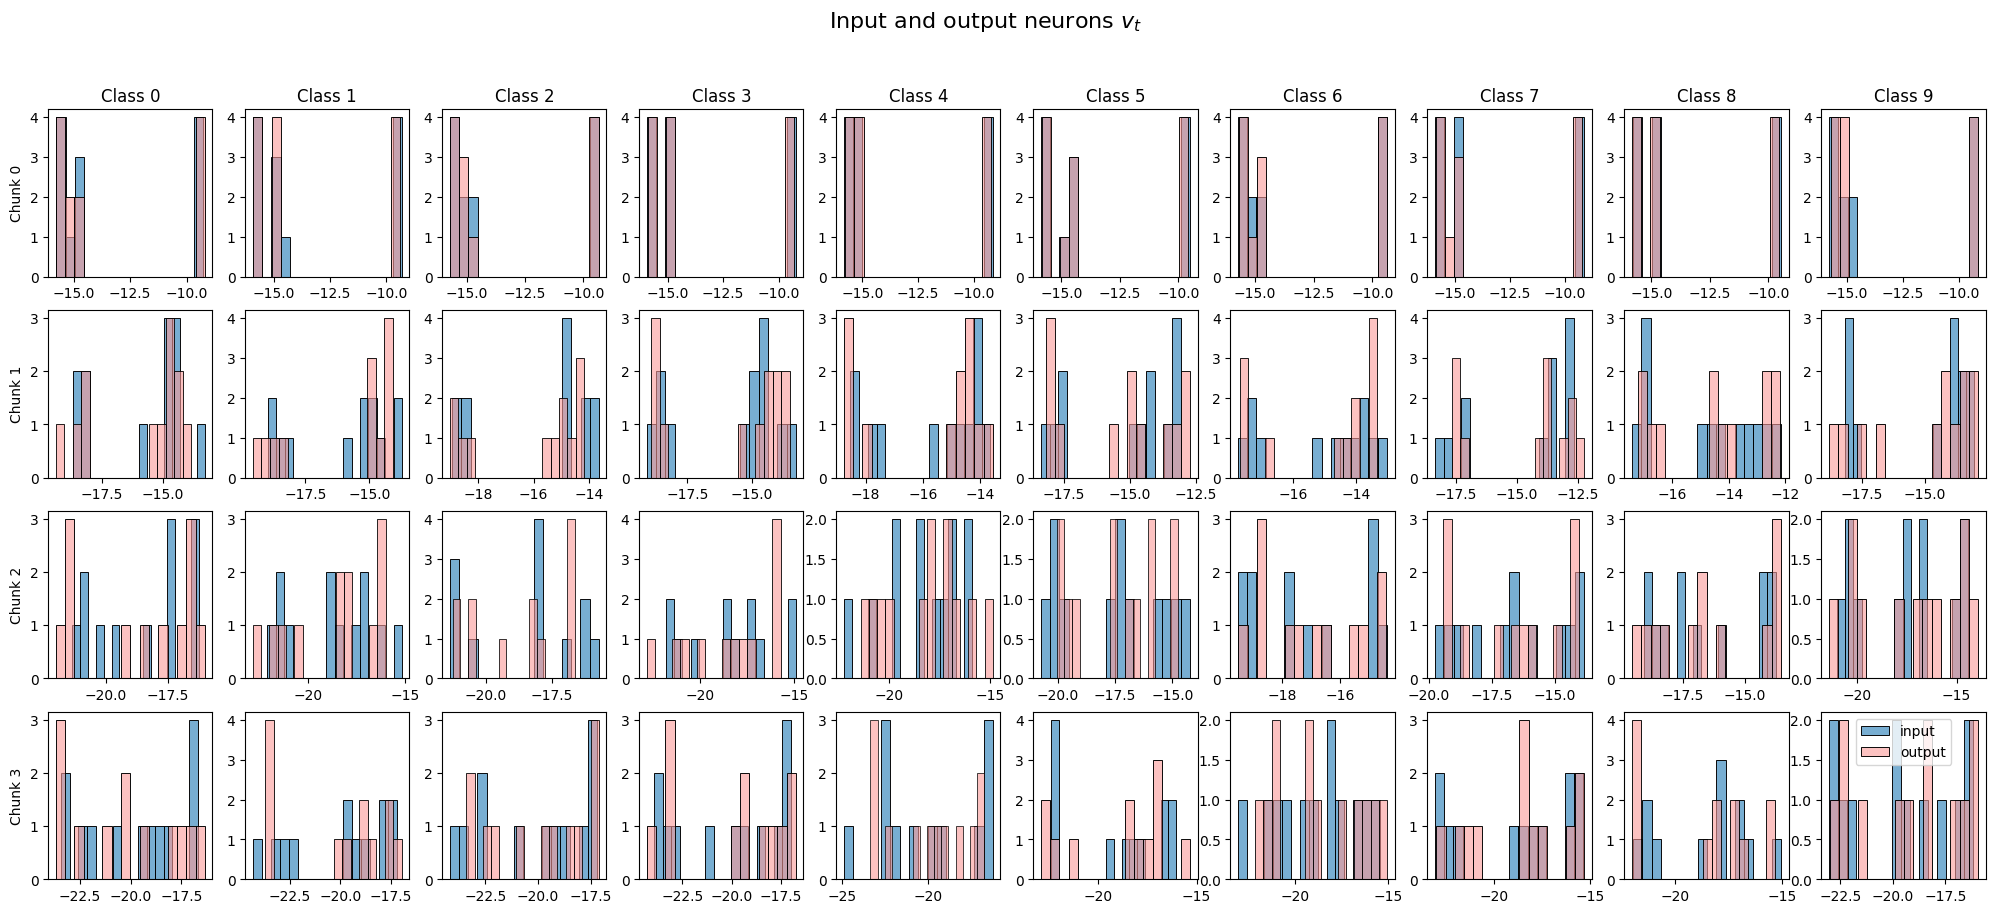

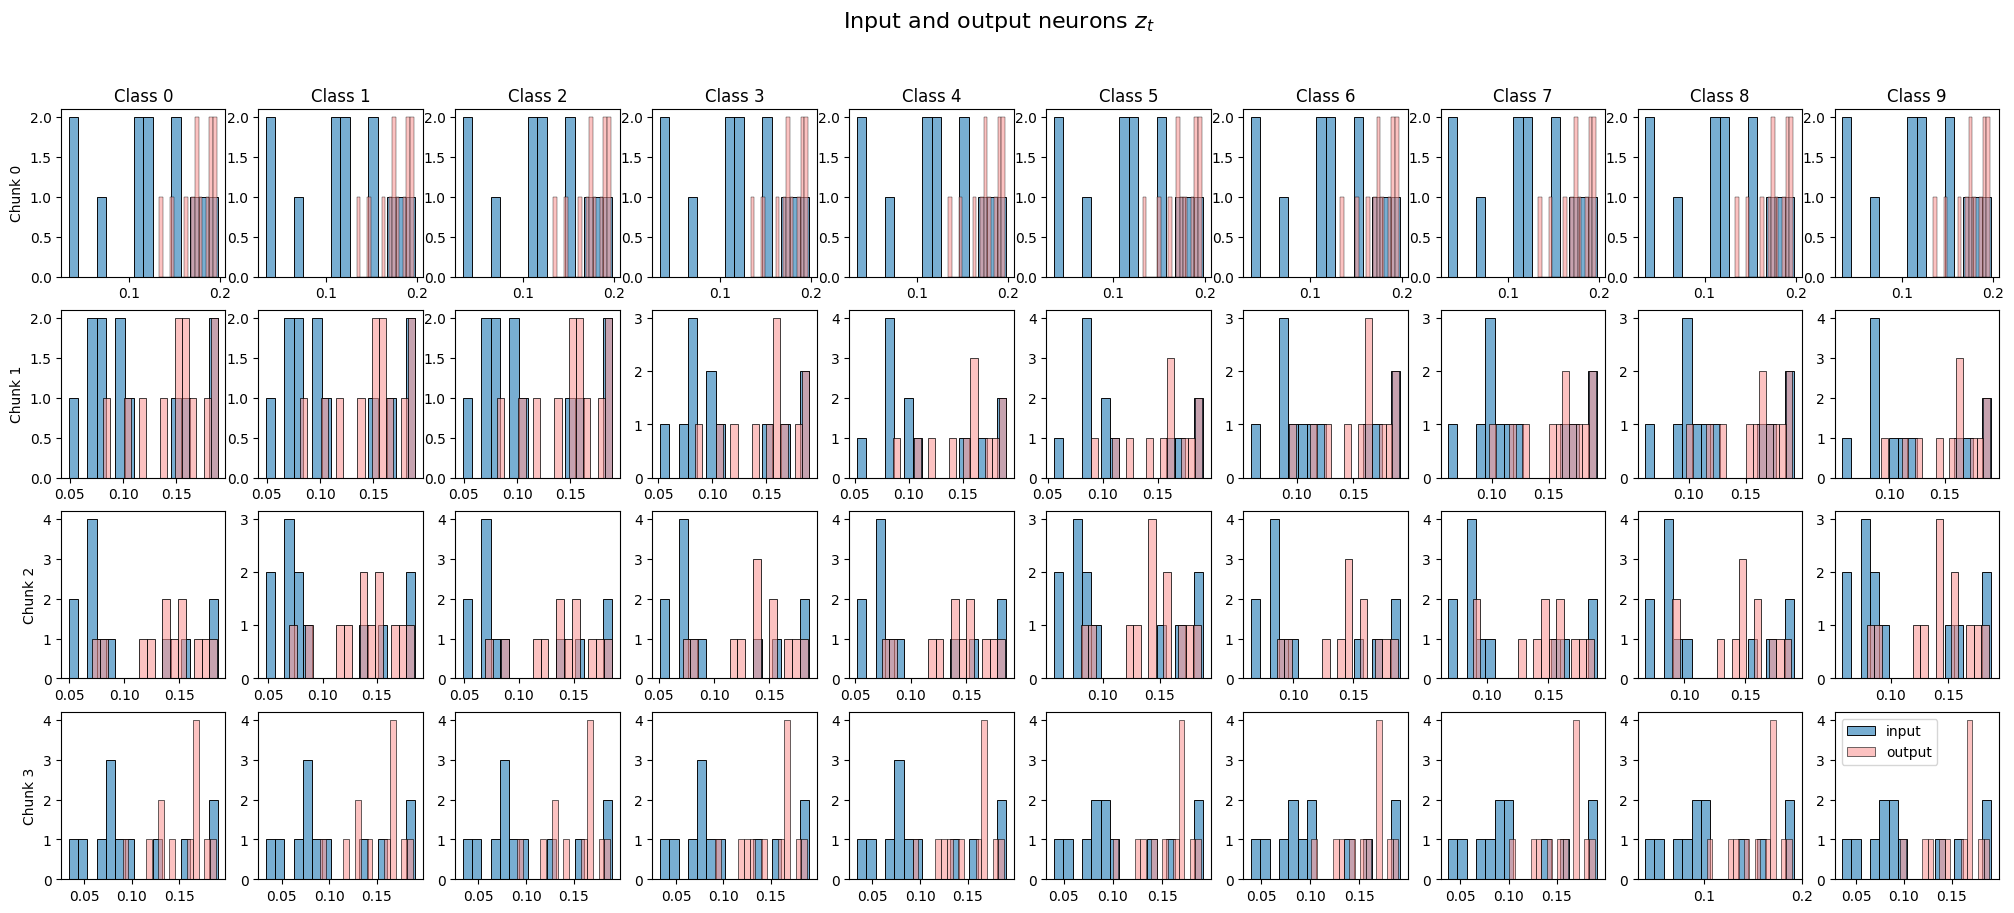

In [21]:
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
pal = sns.color_palette("Paired", 8)
ic = pal[1]
oc = pal[4]

def hist_io(X_ta_input, X_ta_output, y):
    fig, axs = plt.subplots(4, 10, figsize=(25, 10))
    # use seaborn to plot histograms
    import seaborn as sns
    for i in range(10):
        for j in range(4):
            ax = axs[j, i]
            
            sns.histplot(X_ta_input[:,i, j], ax=ax, bins = 16, color=ic, alpha=0.6)
            sns.histplot(X_ta_output[:,i, j], ax=ax, bins = 16, color=oc, alpha=0.6)
            plt.legend(['input', 'output'])
            # set title for first row
            if j == 0:
                ax.set_title(f'Class {i}')
            # set y label for first column
            if i == 0:
                ax.set_ylabel(f'Chunk {j}')
            # remove y label for other columns
            else:
                ax.set_ylabel('')
    fig.suptitle(f'Input and output neurons {y}', fontsize=16)
    plt.show()
    return fig

fig_v = hist_io(v_ta_input, v_ta_output, y=r'$v_t$')
fig_z = hist_io(z_ta_input, z_ta_output, y=r'$z_t$')

# generate same figures for other 3 variables


# Save in PDF
with PdfPages('1.1_histograms_03.pdf') as pdf:
    # Text page with parameters
    text_page = plt.figure(figsize=(8, 10))
    text_page.clf()  # Clear the figure
    text_content = f"""
    Superposed Histogram of Input and Output Neurons of Dynamic Variables

    Parameters:
    Input Size: {input_size}
    Sequence Length: {sequence_length}
    Hidden Size: {hidden_size}
    Number of Layers: {num_layers}
    Number of Classes: {num_classes}
    Batch Size: {batch_size}
    Number of Epochs: {num_epochs}
    Learning Rate: {learning_rate}
    Stride Number: {stride_number}
    """
    text_page.text(0.5, 0.5, text_content, ha='center', va='center', fontsize=12)
    pdf.savefig(text_page)
    plt.close(text_page)

    # Save figures
    for fig in [fig_v, fig_z]:
        pdf.savefig(fig)
        plt.close(fig)



### Scatter plots of dynamic variables

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Assuming the data arrays (X_ta_input, X_ta_output, etc.) are already defined

def scat_io(X_ta_input, X_ta_output, U_ta_input, U_ta_output, x, y):
    fig, axs = plt.subplots(4, 10, figsize=(20, 8))  # Adjust the grid size if needed
    pal = sns.color_palette("Paired", 8)
    ic = pal[1]  # Input color
    oc = pal[4]  # Output color
    
    for i in range(10):  # Adjust range if you want a 4x4 grid
        for j in range(4):
            ax = axs[j, i]
            
            # Plotting input neurons
            sns.scatterplot(x=X_ta_input[:, i, j], y=U_ta_input[:, i, j], ax=ax, color=ic, alpha=0.9, label='Input' if i == 0 and j == 0 else "")
            
            # Plotting output neurons
            sns.scatterplot(x=X_ta_output[:, i, j], y=U_ta_output[:, i, j], ax=ax, color=oc, alpha=0.9, label='Output' if i == 0 and j == 0 else "")
            
            if j == 0:
                ax.set_title(f'Class {i}')
            if i == 0:
                ax.set_ylabel(f'Chunk {j}')
            else:
                ax.set_ylabel('')
                
            # Adding legend to only the first subplot for clarity
            if i == 0 and j == 0:
                ax.legend()
    
    fig.suptitle(f'Input and Output Neurons Scatter Plot for {x} and {y}', fontsize=16)
    fig.supxlabel(f'{x}')
    fig.supylabel(f'{y}')
    plt.tight_layout()
    return fig

# Example usage of the function with dummy data

fig_zv = scat_io(z_ta_input, z_ta_output, v_ta_input, v_ta_output, x=r'$z_t$', y=r'$v_t$')


# Save the figures in PDF
with PdfPages('1.2_scatter_03.pdf') as pdf:
    # Text page with parameters
    text_page = plt.figure(figsize=(8, 10))
    text_page.clf()  # Clear the figure
    text_content = f"""
    Superposed Histogram of Input and Output Neurons of Dynamic Variables

    Parameters:
    Input Size: {input_size}
    Sequence Length: {sequence_length}
    Hidden Size: {hidden_size}
    Number of Layers: {num_layers}
    Number of Classes: {num_classes}
    Batch Size: {batch_size}
    Number of Epochs: {num_epochs}
    Learning Rate: {learning_rate}
    Stride Number: {stride_number}
    """
    text_page.text(0.5, 0.5, text_content, ha='center', va='center', fontsize=12)
    pdf.savefig(text_page)
    plt.close(text_page)

    # Save the scatter plots
    for fig in [fig_zv]:
        pdf.savefig(fig)
        plt.close(fig)


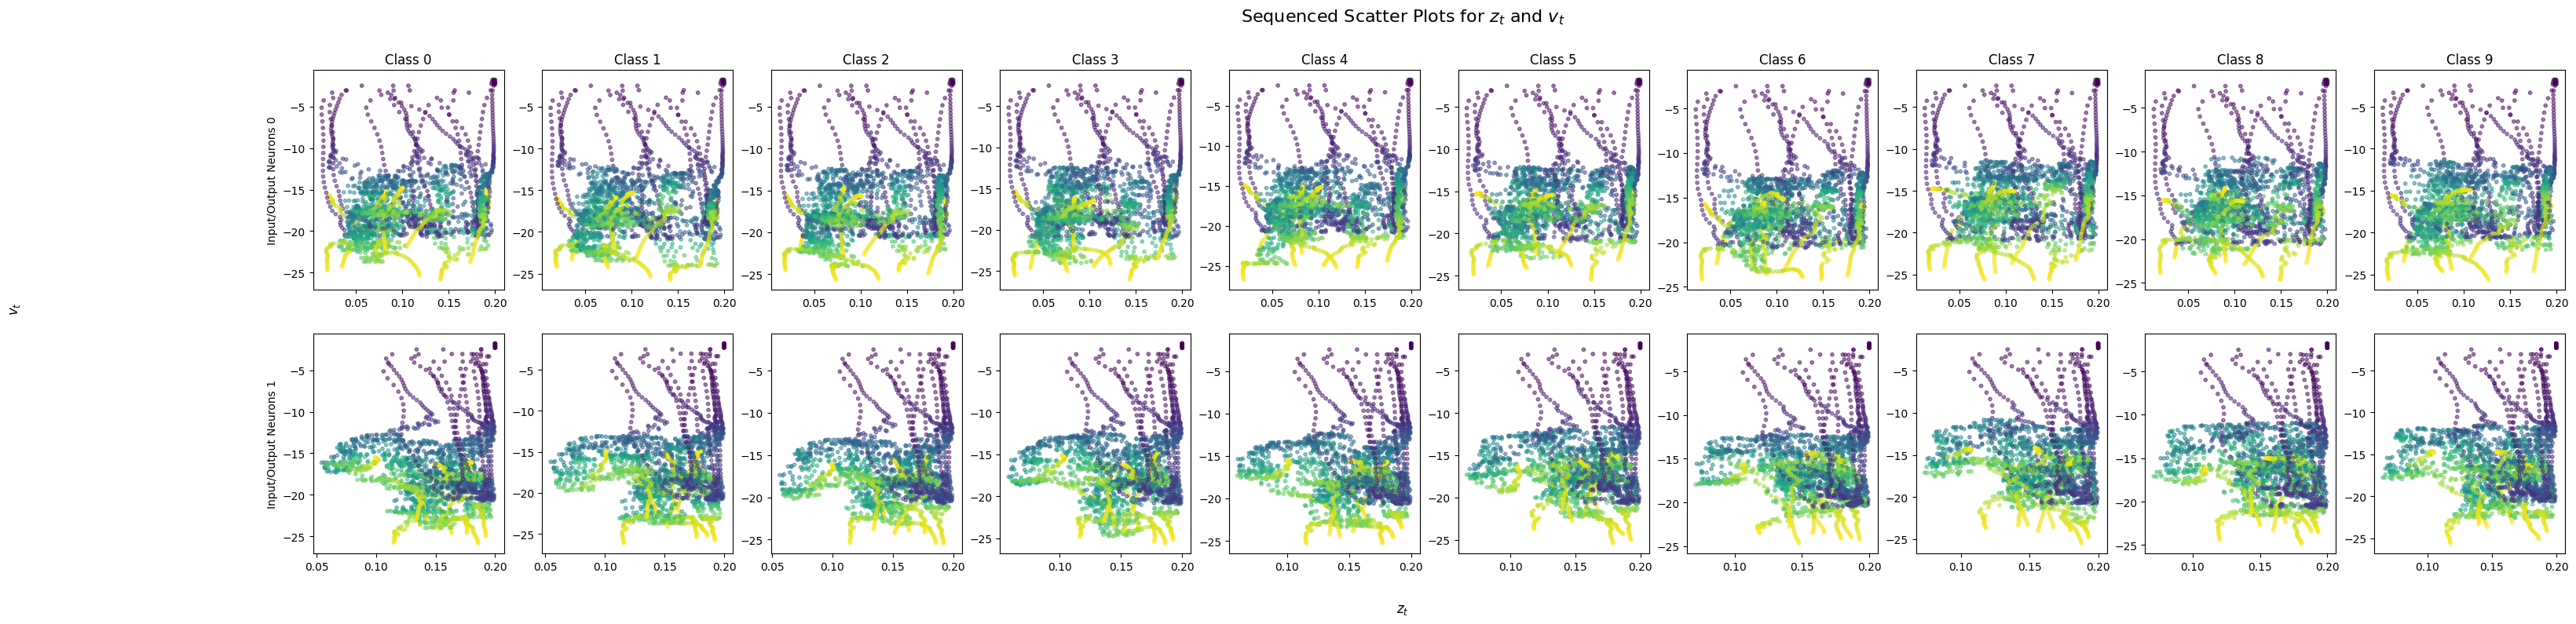

In [24]:
# X_nit (10, 196, 24)
def seqscat_io(X_nit, U_nit, x, y):
    fig, axs = plt.subplots(2, 10, figsize=(37, 8))  # Adjust the grid size if needed

    for i in range(10):  # Adjust range if you want a 4x4 grid
        for j in range(2):
            ax = axs[j, i]
            
            for k in range(12):
                ax.scatter(X_nit[i, :, k+j*12], U_nit[i,:,k+j*12],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')     
                       
            if j == 0:
                ax.set_title(f'Class {i}')
            if i == 0:
                ax.set_ylabel(f'Input/Output Neurons {j}')
            else:
                ax.set_ylabel('')
    
    fig.suptitle(f'Sequenced Scatter Plots for {x} and {y}', fontsize=16)
    fig.supxlabel(f'{x}')
    fig.supylabel(f'{y}')
    plt.show()
    return fig

# all 6 combinations
fig_zv = seqscat_io(z_nit, v_nit, x=r'$z_t$', y=r'$v_t$')




# Save the figures in PDF
with PdfPages('1.3_seqscat_03.pdf') as pdf:
    # Text page with parameters
    text_page = plt.figure(figsize=(8, 10))
    text_page.clf()  # Clear the figure
    text_content = f"""
    Superposed Histogram of Input and Output Neurons of Dynamic Variables

    Parameters:
    Input Size: {input_size}
    Sequence Length: {sequence_length}
    Hidden Size: {hidden_size}
    Number of Layers: {num_layers}
    Number of Classes: {num_classes}
    Batch Size: {batch_size}
    Number of Epochs: {num_epochs}
    Learning Rate: {learning_rate}
    Stride Number: {stride_number}
    """
    text_page.text(0.5, 0.5, text_content, ha='center', va='center', fontsize=12)
    pdf.savefig(text_page)
    plt.close(text_page)

    # Save the scatter plots
    for fig in [fig_zv]:
        pdf.savefig(fig)
        plt.close(fig)

In [ ]:

#clear plot
plt.figure(figsize=(8,6))
for j in range(10):
    for i in range(12):
        plt.scatter(X_nit[0, :,i], U_nit[0,:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
    plt.xlabel('X')
    plt.ylabel('U')
    plt.colorbar()
    plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5)
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
for i in range(10):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i),s = 10, alpha=0.5)
plt.xlabel('v')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('v')
plt.ylabel('z')
plt.colorbar()
plt.show()


In [ ]:

#clear plot
plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('X')
plt.ylabel('U')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5)
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
for i in range(10):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i),s = 10, alpha=0.5)
plt.xlabel('v')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('v')
plt.ylabel('z')
plt.colorbar()
plt.show()


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D

def pca(X_nit, x):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(10):
        u, s, v = np.linalg.svd(X_nit[i])
        P = v[:,:3]
        Y = X_nit[i] @ P
        # 3d scatter plot
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=np.arange(Y.shape[0]), cmap='viridis', alpha=0.5)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'PCA of {x}')
    return fig, ax  # Return both the figure and the axes

# Assuming you have input_size, sequence_length, etc. defined above

# Generate PCA plots

fig_v, ax_v = pca(v_nit, x=r'$v_t$')
fig_z, ax_z = pca(z_nit, x=r'$z_t$')

# Save in PDF
with PdfPages('1.4_PCA_03.pdf') as pdf:
    # Text page with parameters
    text_page = plt.figure(figsize=(8, 10))
    text_page.clf()  # Clear the figure
    text_content = f"""
    PCA of Dynamic Variables

    Parameters:
    Input Size: {input_size}
    Sequence Length: {sequence_length}
    Hidden Size: {hidden_size}
    Number of Layers: {num_layers}
    Number of Classes: {num_classes}
    Batch Size: {batch_size}
    Number of Epochs: {num_epochs}
    Learning Rate: {learning_rate}
    Stride Number: {stride_number}
    """
    text_page.text(0.5, 0.5, text_content, ha='center', va='center', fontsize=12)
    pdf.savefig(text_page)
    plt.close(text_page)

    # Save figures
    for fig in [fig_v, fig_z]:
        pdf.savefig(fig)
        plt.close(fig)
